In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#%cd /content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation
%cd /content/drive/MyDrive/diffusion/generative-inverse-heat-dissipation

/content/drive/.shortcut-targets-by-id/10DJu4TqH_H_4VmdC2S9-vHrJHIb6GZaj/diffusion/generative-inverse-heat-dissipation


In [3]:
!pip install blobfile -q
!pip install ml_collections -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from configs.cifar10 import  default_cifar10_configs
from model_code import utils as mutils
import torch
import numpy as np
import os
from scripts import sampling
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scripts import datasets
from torchvision.io import read_image
from torchvision import transforms

config = default_cifar10_configs.get_config()
config.device

device(type='cpu')

In [3]:
def show_batch_imgs(imgs,nrow=4):
    img_grid = make_grid(imgs,nrow=nrow,padding=2)
    img_tmp = torchvision.transforms.ToPILImage()(img_grid)
    display(img_tmp) # img_tmp.show()
    #fig=plt.figure()
    #fig.set_size_inches(1,8)
    #plt.imshow(img_grid.permute(1,2,0))
    #plt.axis('off')
    #plt.show()
    return

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


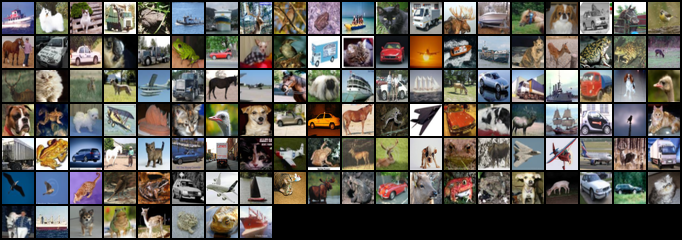

In [4]:
batch_size = 128
trainloader, _ = datasets.get_dataset(config,
                        uniform_dequantization=config.data.uniform_dequantization,
                        train_batch_size=batch_size)
original_images = next(iter(trainloader))[0].to(config.device)
#original_images = initial_sample.clone()
show_batch_imgs(original_images,20)

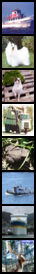

torch.Size([8, 3, 32, 32])

In [5]:
#original_img = original_images[74][None,:,:,:]  #[1, 3, 32, 32] #42/45
original_img = original_images[:8,:,:,:]  #[1, 3, 32, 32] #42/45
show_batch_imgs(original_img,1)
original_img.shape

torch.Size([1, 3, 128, 128])


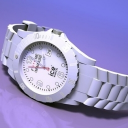

In [ ]:
#img_path =  './data/image_2.jpg'
img_path =  './Linnaeus/Linnaeus 5 256X256/train/other/63_256.jpg'
img_arr=read_image(img_path)

img_arr = torch.from_numpy(np.array(img_arr))/255  # normalize between 0-1
#imgs = min_max_norm_batch_0_1(imgs)
transform = transforms.Resize(size=(128,128),antialias=False)
original_img = transform(img_arr)
original_img = original_img[None,:,:,:]
#imgs[:] = img_arr[:,:,:]  # select index of images in dataset، for all imgs pls ignore this line
print(original_img.shape)
show_batch_imgs(original_img)
config.data.image_size = original_img.shape[-1]

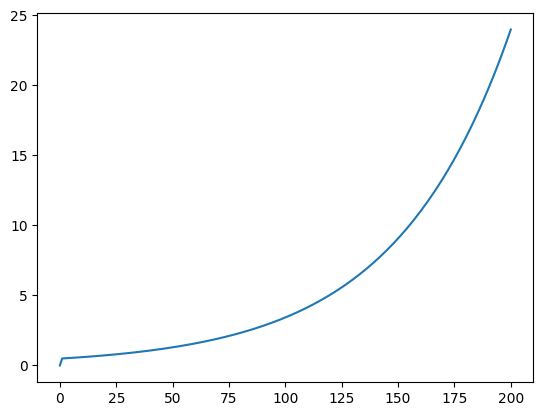

In [ ]:
config.model.dctblur_sigma_max = 24
config.model.dctblur_sigma_min = 0.5
config.model.dctblur_schedule = np.exp(np.linspace(np.log(config.model.dctblur_sigma_min),
                                          np.log(config.model.dctblur_sigma_max), config.model.K))
config.model.dctblur_schedule = np.array([0] + list(config.model.dctblur_schedule))  # Add the k=0 timestep
plt.plot(config.model.dctblur_schedule)

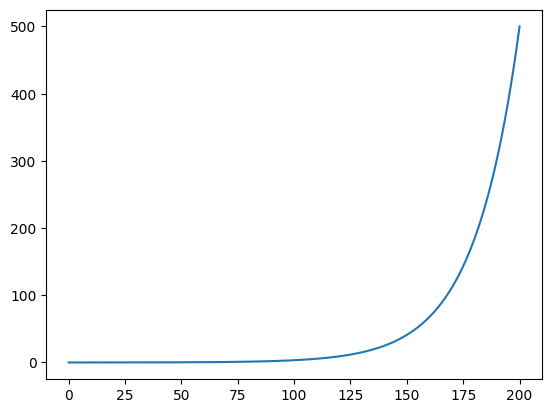

In [ ]:
config.model.fftblur_sigma_max = 500   ###image_width*32
config.model.fftblur_sigma_min = 0.00001    ###
config.model.fftblur_b = 20 ### curvature
config.model.fftblur_a = (config.model.fftblur_sigma_max-config.model.fftblur_sigma_min) / (np.exp(config.model.K/config.model.fftblur_b)-1)
config.model.fftblur_steps = np.arange(0,config.model.K+1)  # 0 .. K-1
config.model.fftblur_schedule = config.model.fftblur_a*(np.exp(config.model.fftblur_steps/config.model.fftblur_b)-1) + config.model.fftblur_sigma_min
plt.plot(config.model.fftblur_schedule)

In [18]:
n_step = 32
step_list = torch.round(torch.linspace(0,config.model.K,n_step)).long()  # [0,...,K]
print(step_list)
initial_sample_dict = {} #'dctblur':[],'fftblur':[]
for blur_type in ['dctblur','fftblur']:
  scales = config.model.dctblur_schedule if blur_type == 'dctblur' else config.model.fftblur_schedule

  forward_heat_module = mutils.create_forward_process_from_sigmas(
                                config, scales, config.device,blur_type)
  initial_sample_dict[blur_type] = forward_heat_module(original_img,step_list)

  print(f'{blur_type} :')
  print('shape = ',initial_sample_dict[blur_type].shape)
  show_batch_imgs(initial_sample_dict[blur_type],n_step)

tensor([  0,   6,  13,  19,  26,  32,  39,  45,  52,  58,  65,  71,  77,  84,
         90,  97, 103, 110, 116, 123, 129, 135, 142, 148, 155, 161, 168, 174,
        181, 187, 194, 200])


RuntimeError: The size of tensor a (8) must match the size of tensor b (32) at non-singleton dimension 0

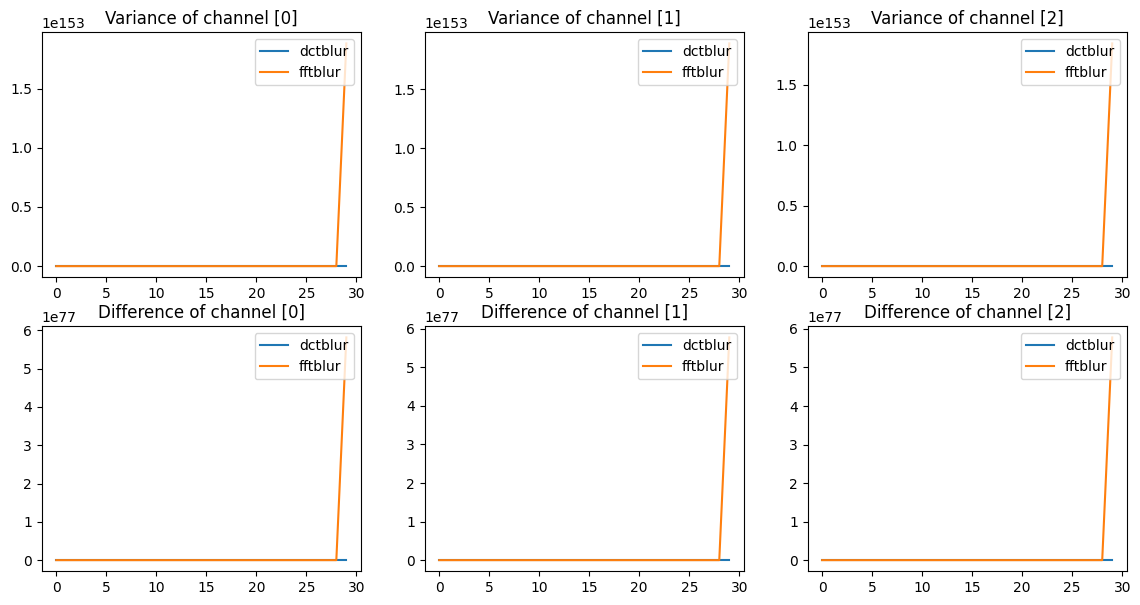

In [ ]:
sample_var  = {'dctblur':[],'fftblur':[]}
sample_diff = {'dctblur':[],'fftblur':[]}
for i in range(len(step_list)):
    for blur_type in ['dctblur','fftblur']:
        sample = initial_sample_dict[blur_type][i].reshape(3,-1)
        sample_var[blur_type].append(torch.var(sample,dim=1))
        sample_diff[blur_type].append(torch.max(sample,dim=1).values - torch.min(sample,dim=1).values)

fig,axes = plt.subplots(2,3,figsize=(14,7))

for channel,_ in enumerate(['Red','Green','Blue']):
    for blur_type in ['dctblur','fftblur']:
        sampel_var_arr = np.array(sample_var[blur_type]).transpose(1,0)
        axes[0,channel].plot(sampel_var_arr[channel],label=blur_type)
    axes[0,channel].set_title(f'Variance of channel [{channel}]')
    axes[0,channel].legend(loc="upper right")

    for blur_type in ['dctblur','fftblur']:
        sample_diff_arr = np.array(sample_diff[blur_type]).transpose(1,0)
        axes[1,channel].plot(sample_diff_arr[channel],label=blur_type)
    axes[1,channel].set_title(f'Difference of channel [{channel}]')
    axes[1,channel].legend(loc="upper right")

plt.show()

In [ ]:
np.array(sample_diff['dctblur']).transpose(1,0)[channel][len(step_list)-1],np.array(sample_diff['fftblur']).transpose(1,0)[channel][len(step_list)-1]

(0.020642538301257563, 0.007064927345377892)

In [ ]:
var = np.array(sample_var['fftblur']).transpose(1,0)[0]
var

array([6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66911254e-02, 6.66911254e-02, 6.66911254e-02, 6.66911254e-02,
       6.66860104e-02, 1.93329583e-06])

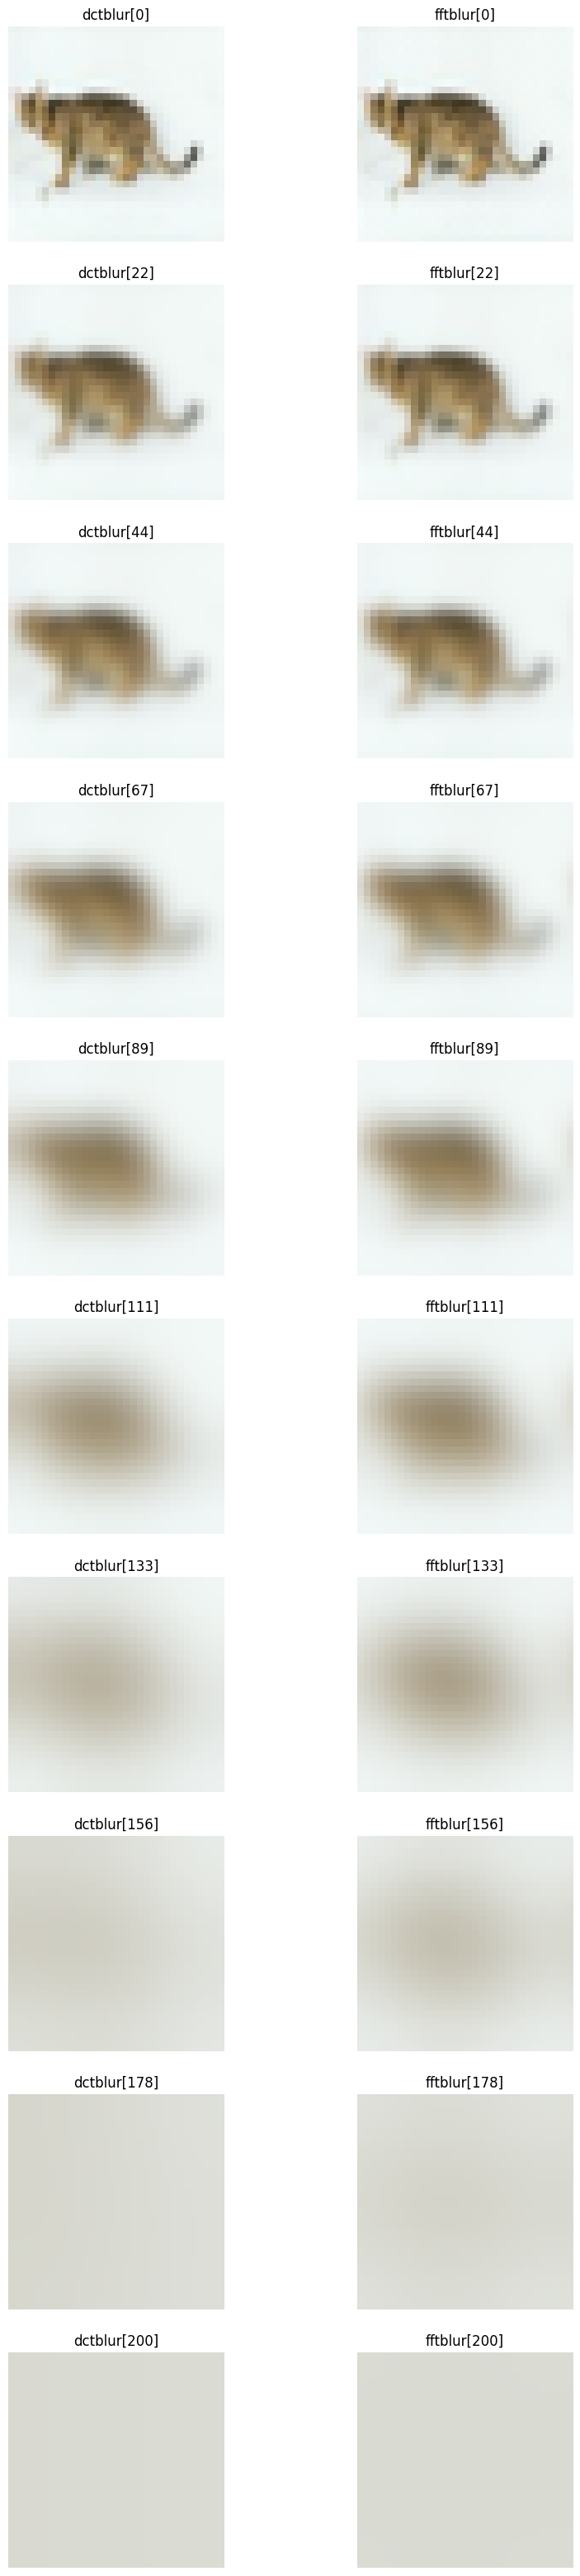

In [ ]:
n_step = 10
step_list = torch.round(torch.linspace(0,config.model.K,n_step)).long()  # [0,...,K]

fig, axes = plt.subplots(n_step,2,figsize=(10,4*n_step))
#fig.dpi=300
nrow = 8
initial_sample_dict = {'dctblur':[],'fftblur':[]}
for row,blur_step in enumerate(step_list):
    for col,blur_type in enumerate(['dctblur','fftblur']):

        if blur_type == 'dctblur' :
            scales = config.model.dctblur_schedule
        else:
            scales = config.model.fftblur_schedule

        heat_forward_module = mutils.create_forward_process_from_sigmas(config, scales, config.device,blur_type)

        initial_sample = heat_forward_module(original_images, #config.model.K *
                           blur_step * torch.ones(initial_sample.shape[0], dtype=torch.long).to(config.device))
        initial_sample_dict[blur_type].append(initial_sample)

        img_grid = make_grid(initial_sample,nrow=nrow,padding=2)
        axes[row,col].imshow(img_grid.permute(1,2,0).cpu().detach().numpy())
        axes[row,col].set_title(f'{blur_type}[{blur_step}]')
        axes[row,col].axis('off')
plt.show()


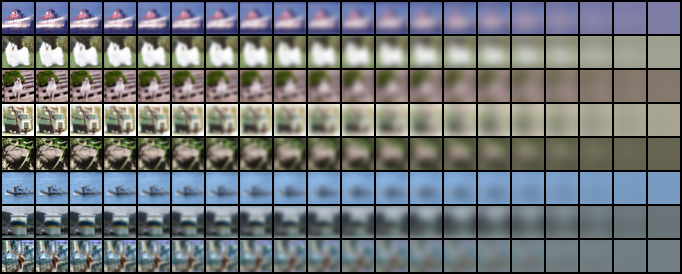

In [6]:
n_step = 20
step_list = torch.round(torch.linspace(0,config.model.K,n_step)).long()  # [0,...,K]
imgs_blurring = []
blur_type = 'fftblur'
for step in step_list:
    scales = config.model.fftblur_schedule

    forward_heat_module = mutils.create_forward_process_from_sigmas(
                                config, scales, config.device,blur_type)
    multi_step = torch.full((original_img.shape[0],),step)
    imgs_blurring.append(forward_heat_module(original_img,multi_step))

imgs_blurring = torch.from_numpy(np.array(imgs_blurring))
imgs_blurring1 = imgs_blurring.permute(1,0,2,3,4).reshape(-1,3,32,32)
show_batch_imgs(imgs_blurring1,n_step)